In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [13]:
path = '/content/drive/Othercomputers/내 PC/DEV/DSL/세션2/정규세션/[0804] Supervised_learning'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [7]:
os.getcwd()

'/content/drive/Othercomputers/내 PC/DEV/DSL/세션2/정규세션/[0804] Supervised_learning/data'

In [14]:
!ls

'[0804]supervised_learning.ipynb'	 data
'[0804]Supervised_learning_과제.ipynb'	 figure
'[0804] Supervised Learning 세션.pdf'


사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [9]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [10]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [11]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [47]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [48]:
train_x.head()

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


In [25]:
train_tot = pd.concat([train_x, train_y], axis=1)
train_tot.head()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
0,17.6,2.5,92.0,0.8,0.0,8179.056
1,17.7,2.9,91.0,0.3,0.0,8135.640
2,17.5,3.2,91.0,0.0,0.0,8107.128
3,17.1,3.2,91.0,0.0,0.0,8048.808
4,17.0,3.3,92.0,0.0,0.0,8043.624


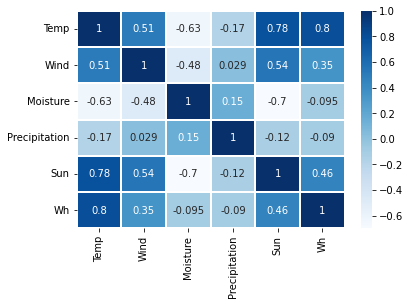

In [26]:
import seaborn as sns

sns.heatmap(train_tot.corr(), annot=True, cmap='Blues', linewidth=1)

Wh와 다른 변수들간의 상관관계를 보았을때 Temp 변수와의 지수가 매우 높게 나타난다. 이를 그래프를 그려 구체적으로 어떤 관계를 보이는지 살펴보자

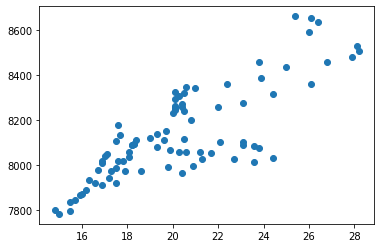

In [28]:
plt.scatter(train_x.Temp, train_y)
plt.show()

그래프를 통해 어느 정도 선형관계가 형성되어 있음을 관찰할 수 있다.

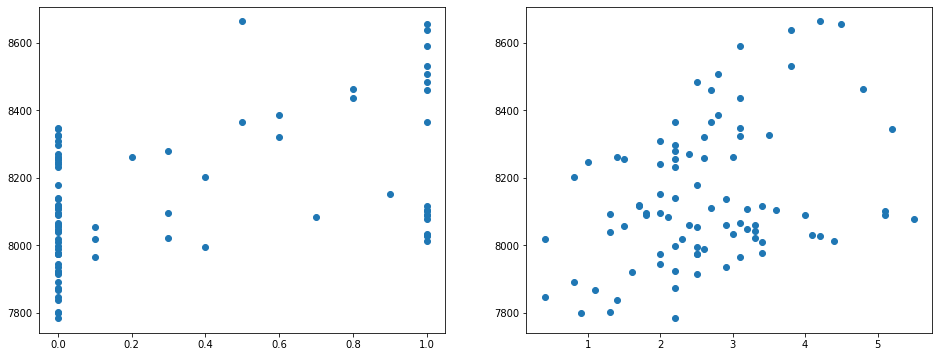

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 6)) 

plt.subplot(1, 2, 1)
plt.scatter(train_x.Sun, train_y)

plt.subplot(1, 2, 2)
plt.scatter(train_x.Wind, train_y)

plt.show()

0.35, 0.46 정도의 상관관계를 보인 Sun과 Wind는 유의미한 관계를 보이지 않고 있다. 하지만 연습을 위해 

In [49]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
train_x = train_x.Temp

In [50]:
train_x

0     17.6
1     17.7
2     17.5
3     17.1
4     17.0
      ... 
83    23.9
84    25.0
85    26.0
86    26.4
87    25.4
Name: Temp, Length: 88, dtype: float64

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : Temp

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [41]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [51]:
train_x_np = np.array(train_x)
train_x_np.shape

(88,)

In [52]:
train_x_np = train_x_np[:, np.newaxis]
train_x_np.shape

(88, 1)

In [53]:
train_x_np[:5]

array([[17.6],
       [17.7],
       [17.5],
       [17.1],
       [17. ]])

In [54]:
scaler = StandardScaler()
train_x_np = scaler.fit_transform(train_x_np)
train_x_np[:5]

array([[-0.80942259],
       [-0.77879955],
       [-0.84004563],
       [-0.96253778],
       [-0.99316082]])

In [55]:
train_x_np[-5:]

array([[1.11982885],
       [1.45668227],
       [1.76291266],
       [1.88540481],
       [1.57917443]])

In [56]:
train_x_np.shape

(88, 1)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [57]:
# 사용할 패키지를 import!
from sklearn.linear_model import Ridge

Ridge Regression 활용 (with 1차항 변수)

In [58]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
ridge_model = Ridge().fit(train_x_np, train_y)

In [63]:
ridge_beta = ridge_model.coef_
ridge_intercept = ridge_model.intercept_
print(f"Beta :{ridge_beta}")
print(f"Intercept : {ridge_intercept: .4f}")

Beta :[160.83255765]
Intercept :  8142.1863


## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [67]:
esti_y = ridge_model.predict(train_x_np)

In [70]:
esti_y.shape

(88,)

In [71]:
train_y.shape

(88,)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [68]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [69]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 14547.09856


In [73]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

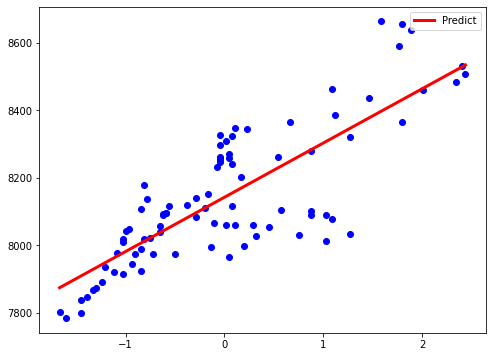

In [77]:
# visualization 하실 분은 진행해주세요!
visualize(ridge_model, train_x_np, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [79]:
test_x = test_x.Temp
test_x

88    24.3
89    23.2
90    22.8
91    21.7
92    21.4
93    20.8
94    20.3
95    19.9
96    19.7
97    19.5
98    19.3
99    19.3
Name: Temp, dtype: float64

In [80]:
test_x = np.array(test_x)
test_x = test_x[:, np.newaxis]
test_x.shape

(12, 1)

In [81]:
# transform을 하시는 분들은 실행해주세요
test_x = scaler.transform(test_x)
test_x

array([[ 1.242321  ],
       [ 0.90546758],
       [ 0.78297542],
       [ 0.446122  ],
       [ 0.35425288],
       [ 0.17051465],
       [ 0.01739945],
       [-0.1050927 ],
       [-0.16633878],
       [-0.22758486],
       [-0.28883093],
       [-0.28883093]])

In [82]:
# y1_hat에 predict값 할당
pred_y = ridge_model.predict(test_x)
pred_y

array([8341.99193685, 8287.81493885, 8268.1142123 , 8213.9372143 ,
       8199.16166939, 8169.61057957, 8144.98467138, 8125.28394484,
       8115.43358156, 8105.58321829, 8095.73285502, 8095.73285502])

In [83]:
test_y

88    8671.536
89    8652.096
90    8626.176
91    8665.704
92    8646.264
93    8659.872
94    8657.280
95    8604.144
96    8598.960
97    8573.040
98    8561.376
99    8549.064
Name: Wh, dtype: float64

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [84]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [85]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 198354.83081


In [86]:
score(train_mse,test_mse)

 13.6354


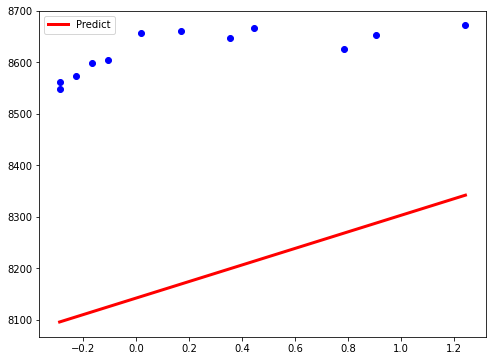

In [88]:
# visualization 하실 분은 진행해주세요!
visualize(ridge_model, test_x, test_y)

매우 좋지 않은 결과가 나왔다. 

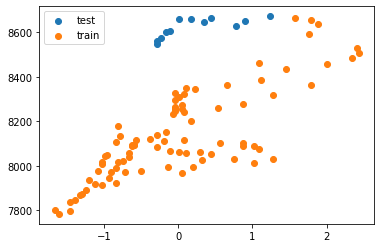

In [89]:
plt.scatter(test_x, test_y, label='test')
plt.scatter(train_x_np, train_y, label='train')
plt.legend()
plt.show()

Scatter Plot을 그렸을 때 기존 선형모델에 벗어나는 x값들로 test data가 구성되어 있음을 확인할 수 있다.<br>
결론) 현재 train data와 test data의 구성이 매우 다르다. 더욱더 많은 train data를 구성하는 식으로 해결이 필요해 보인다.

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!